 This notebook uses a vanilla (basic) Bayesian optimization algorithm to tackle an urban travel demand (i.e.,  origin-destination, OD) calibration problem. The traffic simulations are based on the SUMO simulator. It considers a toy network, called quickstart detailed here:
 https://sumo.dlr.de/docs/Tutorials/quick_start.html

# Install sumo

In [35]:
import importlib
import helpers_od_calibration
importlib.reload(helpers_od_calibration)

<module 'helpers_od_calibration' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/helpers_od_calibration.py'>

Mount GDrive

If you are working w/ colab rather than a jupyterlab notebook this drive mounting and sumo installation will need to be done every time you restart the runtime.


In [36]:
import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci


import json, shutil
from pathlib import Path

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib


base_path = '/Users/inesbenhamza/Desktop/Sumo_od_calibration'
# if base_path has a space in it, the sumo code will not work
if ' ' in base_path:
    raise ValueError("base_path should not contain any spaces.")

os.chdir(base_path)



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize



from helpers_od_calibration import (load_kwargs_config,
                    compute_nrmse_counts_all_edges,
                    parse_loop_data_xml_to_pandas,
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    compute_nrmse_counts_all_edges,
                    )

%matplotlib inline


config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 10,
 'NUM_RESTARTS': 5,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 5,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml'),
 'network_name': 'quickstart',
 'network_path': PosixPath('network/quickstart'),
 'od_duration_sec': 300,
 'sim_end_time': 57600,
 'sim_start_time': 54000,
 'sim_stat_freq_sec': 300,
 'simulation_run_path': 'output/quickstart_bo_vanilla',


Install SUMO

Set sumo env vars

# Create GT (ground truth) scenario

In [37]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)

Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml
total GT demand:  2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv


Simulate the GT scenario to obtain the GT traffic statistics

In [38]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)

# Run simulation
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count  data
0  taz91  taz93  500.0  None
1  taz91  taz94  500.0  None
2  taz92  taz93  900.0  None
3  taz92  taz94  900.0  None
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quic

Read and process the GT simulation outputs

In [39]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"])
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)

Number of GT edges: 14
output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml


# Optimization

Vanilla Bayesian Optimization (BO)


Bayesian optimization utils / helpers

In [16]:
from botorch.optim import optimize_acqf

def initialize_gp_model(train_X, train_Y):
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(
        MaternKernel(
            nu=2.5,
            ard_num_dims=dim,
            lengthscale_constraint=Interval(0.005, 4.0),
        )
    )

    gp_model = SingleTaskGP(
        train_X,
        train_Y,
        covar_module=covar_module,
        likelihood=likelihood,
        outcome_transform=Standardize(m=1),
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    return gp_model, gp_mll


def optimize_acqf_and_get_observation(
    acq_func,
    bounds,         # here: NORMALIZED bounds, e.g. bounds_norm in [0,1]^dim
    device,
    dtype,
    BATCH_SIZE,
    NUM_RESTARTS,
    RAW_SAMPLES,
):
    """
    Optimizes the acquisition function and returns a new candidate in the
    SAME space as `bounds` (here: normalized OD space).
    """

    dim = acq_func.model.train_inputs[0].size(dim=1)

    candidates, _ = optimize_acqf(
        acq_function=acq_func,      # EI over normalized OD space
        bounds=bounds,              # <--- use the given bounds (e.g. bounds_norm)
        q=1,               # 1 = standard sequential BO
        num_restarts=NUM_RESTARTS,  # multistart optimization
        raw_samples=RAW_SAMPLES,    # Sobol init points for EI
        # options={"batch_limit": 5, "maxiter": 200},  # optional
    )

    # Do NOT unnormalize here – return normalized x
    new_x = candidates.detach()
    return new_x

Declare parameter space


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)

cpu
4


## Create and simulate a sample of initial input points (i.e., ODs).

In [41]:
# Sample according to Sobol, drawn are quasi random so need multiple restart !! 
# quasi bc they cover the aparameters space more evenly than pure randomness, they avoid lcuster and gaps so better coverage of space 
#it ensure we can explore differnt regions 
#better initial data, bette gp, better optimization 

seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed) #Sobol sequences are an example of low discrepancy quasi-random sequences.
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device) # generate n_init_search samples, here 5
print (x_0.shape)
#x_0 shape: torch.Size([5, 4]) meaning 5 samples of 4 dimensions each
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
print (train_X0)  #5 samples of 4 dimensions each


print (dim_od)
#4 dimension, 4OD pairs
#so we have 4 pairs so 4 demand values to optimize

Random seed set to 42
torch.Size([5, 4])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374]], dtype=torch.float64)
4


In [42]:
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD, it's entries will be updated at every epoch
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i , x in enumerate(train_X0.tolist()):
      print(f"########### OD: {i} ###########")
      print(x)

      simulation_run_path_init =f'{config["simulation_run_path"]}/initial_search'
      Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

      new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
      prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

      # Generate OD
      #curr_od = gt_od_vals.copy()
      curr_od = np.array(x)

      print(f'total expected GT demand: {np.sum(curr_od)}')

      ###
      # create OD xml file
      ###
      base_od['count'] = curr_od
      # round to 1 decimal point
      base_od['count'] = [round(elem, 1) for elem in base_od['count']]
      base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
      create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)
      ods_epsilon.append(curr_od)

      # simulate initial sample
      simulate_od(new_od_xml,
                  prefix_output_init,
                  base_path,
                  config["net_xml"],
                  config["taz2edge_xml"],
                  config["additional_xml"],
                  routes_df,
                  config["sim_end_time"],
                  config["TRIPS2ODS_OUT_STR"])

      ## Compute loss
      #prefix_output = f'initial_search/sobol_{i}'
      sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
      print(sim_edge_out)
      curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_init,config["SUMO_PATH"])
      curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

      loss_all.append(curr_loss)
      print(f"############## loss: {curr_loss} ##############")

      # Parse training data
      df_curr = pd.DataFrame(curr_od.reshape(1,dim_od),
                        columns = [f"x_{i+1}" for i in range(dim_od)])
      df_curr['loss'] = curr_loss
      batch_data_i.append(df_curr)

df_initial_bo = pd.concat(batch_data_i)
# Save initial dataset
df_initial_bo.to_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv",index=None)
print(f"save df_initial_bo at {config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")


########### OD: 0 ###########
[1995.026707649231, 208.73278379440308, 1645.9577083587646, 838.8643264770508]
total expected GT demand: 4688.5815262794495
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 299.00
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_trips.xml -b 0 -e 57600 --additional-fil

In [20]:
print (base_od)
print (gt_od_vals)

    from     to   count  data
0  taz91  taz93  1172.5  None
1  taz91  taz94   780.6  None
2  taz92  taz93   309.8  None
3  taz92  taz94  1819.2  None
[500. 500. 900. 900.]


## Run BO epochs

In [43]:

from botorch.acquisition import ExpectedImprovement


bounds_norm = torch.stack([
    torch.zeros(dim_od, device=device, dtype=dtype),
    torch.ones(dim_od,  device=device, dtype=dtype),
])



df_0 = pd.read_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")

### Run loop
best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

df_edge_stats = pd.DataFrame()

#num_epsilon_iter = 2
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i in range(config["NITER"]):
    new_od_xml = f'{config["simulation_run_path"]}/od.xml'

    simulation_run_path_BO =f'{config["simulation_run_path"]}/BO'
    prefix_output_bo = f'{simulation_run_path_BO}/bayesOpt_{i}'
    Path(simulation_run_path_BO).mkdir(parents=True, exist_ok=True)

    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    ).to(device=device, dtype=dtype)

    # Normalize
    train_X_norm = normalize(train_X, bounds) # normalizing input 

    # Obtain reponse data
    train_Y = torch.from_numpy(df_training[["loss"]].values) 

    # best value so far
    best_y = train_Y.min()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    print(f"Generating new sampling location(s)....")
    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function
    # sampler = StochasticSampler(sample_shape=torch.Size([128]))
    EI = ExpectedImprovement(gp_model, best_f=best_y, maximize=False )

    # Maximize acquisition function to get next observation
    x_i = optimize_acqf_and_get_observation(acq_func=EI,
                                            bounds=bounds_norm,
                                            device=device,
                                            dtype=dtype,
                                            BATCH_SIZE=config["BATCH_SIZE"],
                                            NUM_RESTARTS=config["NUM_RESTARTS"],
                                            RAW_SAMPLES=config["RAW_SAMPLES"])

    # map the normalized into the original parameter space
    x_i = unnormalize(x_i, bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########


    # Sample simulator (inner loop across all sampling locations within a batch)
    batch_data_i = []
    for j in range(config["BATCH_SIZE"]):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        # simulate gt od
        simulate_od(new_od_xml,
                    prefix_output_bo,
                    base_path,
                    config["net_xml"],
                    config["taz2edge_xml"],
                    config["additional_xml"],
                    routes_df,
                    config["sim_end_time"],
                    config["TRIPS2ODS_OUT_STR"])

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output_bo}_{config["EDGE_OUT_STR"]}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_bo,config["SUMO_PATH"])

        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

        curr_loop_stats['bo_iteration'] = i
        curr_loop_stats['batch'] = j
        df_edge_stats = pd.concat([df_edge_stats, curr_loop_stats])

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=0.0661424585897851 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 2703.2182146630157
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 299.74


/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_0_trips.xml'
Loading done.
Simulation version 1.24.0 start

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_1_trips.xml'
Loading done.
Simulation version 1.24.0 start

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_2_trips.xml'
Loading done.
Simulation 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.84
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_3_trips.xml'
Loading done.
Simulation 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


########### Sampling location=1 ###########
total expected GT demand: 3065.7109043956834
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_4_trips_beforeRteUpdates.xml
Success.time 299.81
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.v

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.93
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_5_trips.xml'
Loading done.
Simulation 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.89
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_6_trips.xml'
Loading done.
Simulation 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


########### Sampling location=1 ###########
total expected GT demand: 2343.565106137251
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_7_trips_beforeRteUpdates.xml
Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.ve

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


########### Sampling location=1 ###########
total expected GT demand: 2877.356326473144
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_8_trips_beforeRteUpdates.xml
Success.time 299.30
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.ve

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


########### Sampling location=1 ###########
total expected GT demand: 1947.353245938098
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_9_trips_beforeRteUpdates.xml
Success.time 299.36
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/bayesOpt_9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/bayesOpt_9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.ve

Store outputs

In [22]:
print(f"saving at {config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_training.to_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv",index=None)

print(f"saving at {config['simulation_run_path']}/BO/df_edge_stats.csv")
df_edge_stats.to_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv",index=None)

saving at output/quickstart_bo_vanilla/BO/data_set_bayes_opt.csv
saving at output/quickstart_bo_vanilla/BO/df_edge_stats.csv


# Results analysis

Convergence plots

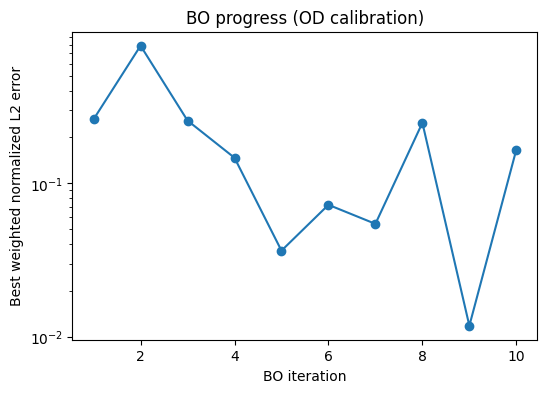

In [44]:
df_training = pd.read_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_edge_stats = pd.read_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv")



df_plot = df_training.query('bo_iteration>0')
x = df_plot['bo_iteration']
y = df_plot['loss']


plt.figure(figsize=(6, 4))
plt.plot(x, y, marker="o")

plt.xlabel("BO iteration")
plt.ylabel("Best weighted normalized L2 error")  # <-- fixed label
plt.title("BO progress (OD calibration)")

# Optional: log scale because values are ~1e-5
plt.yscale("log")


In [34]:
df_training[['bo_iteration','loss']].head(20)

,bo_iteration,loss
0,0,1.542739
1,0,0.866254
2,0,0.066142
3,0,1.275708
4,0,0.562774
5,1,0.261002
6,2,0.786186
7,3,0.255893
8,4,0.146464
9,5,0.036385


In [25]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

Scatter plots: fit to traffic data

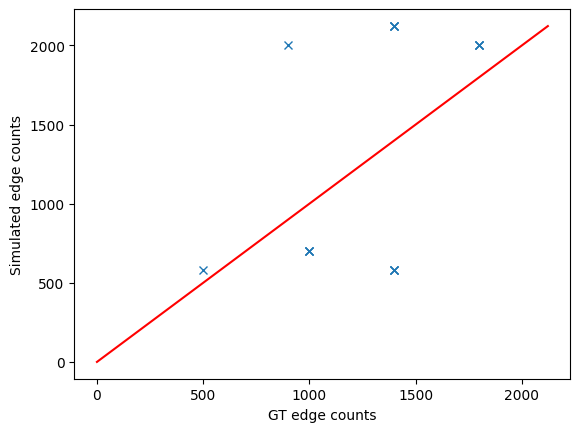

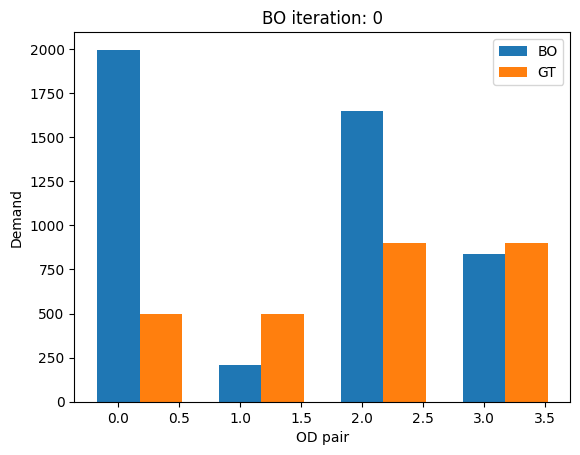

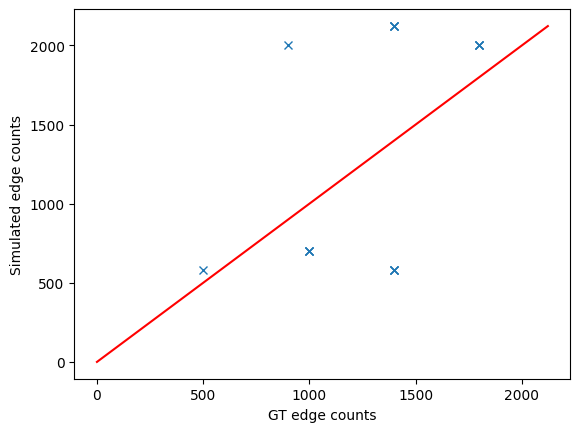

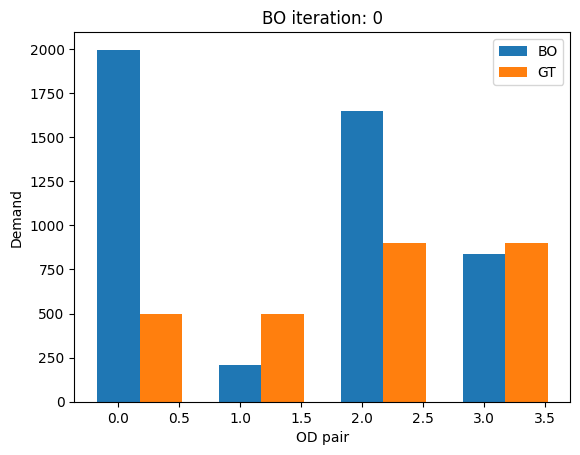

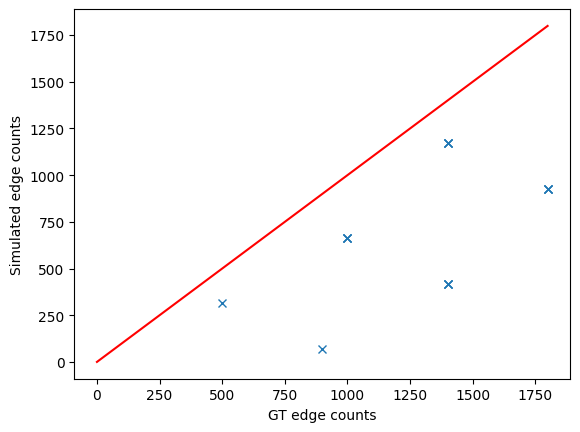

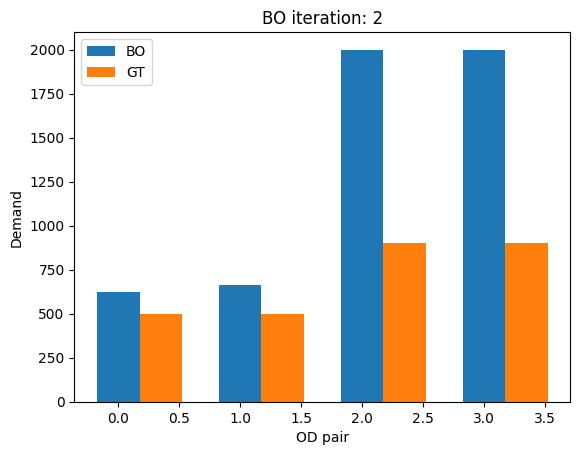

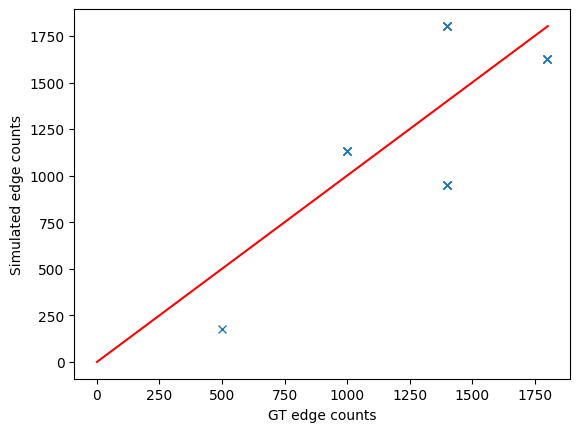

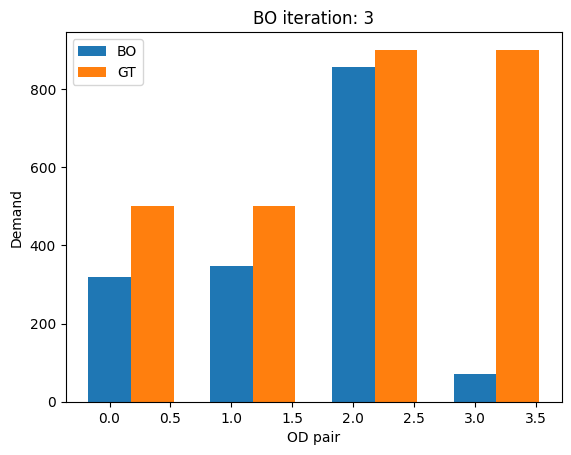

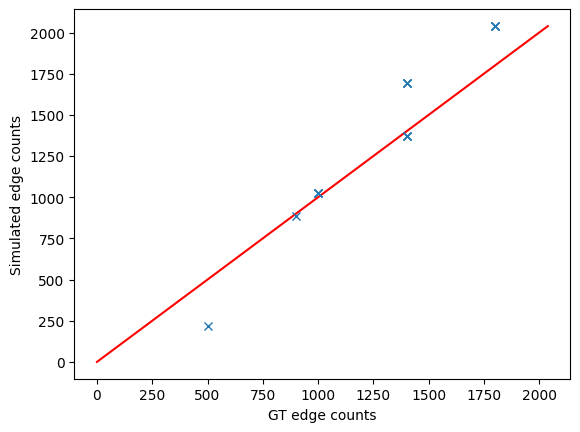

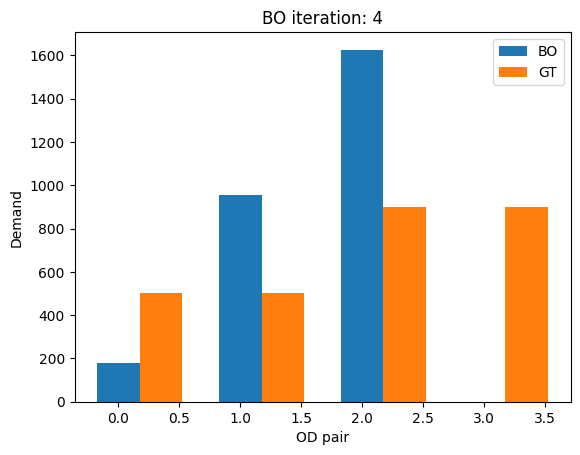

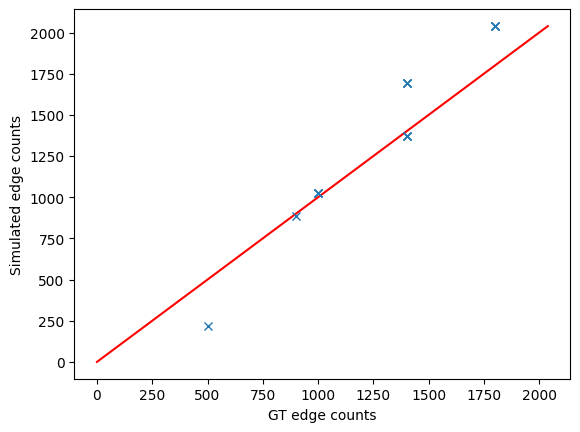

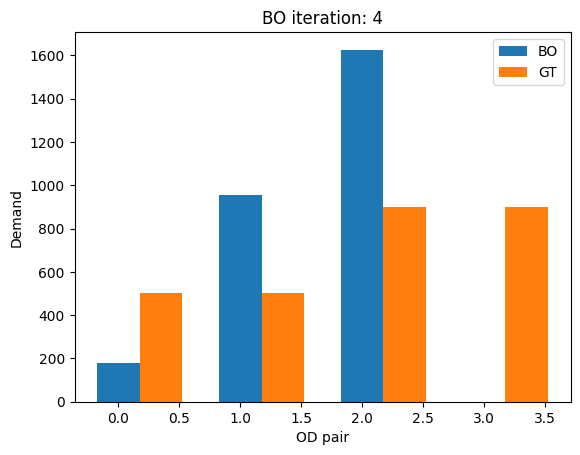

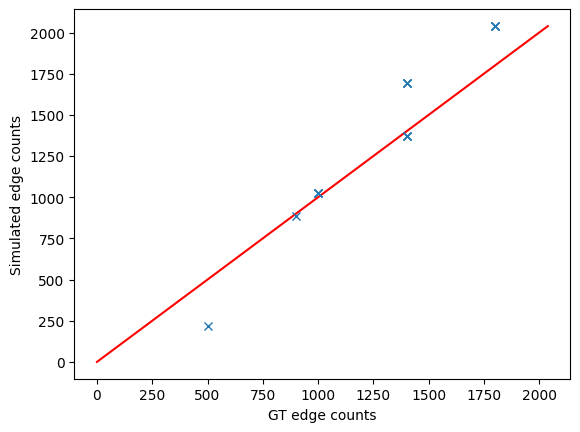

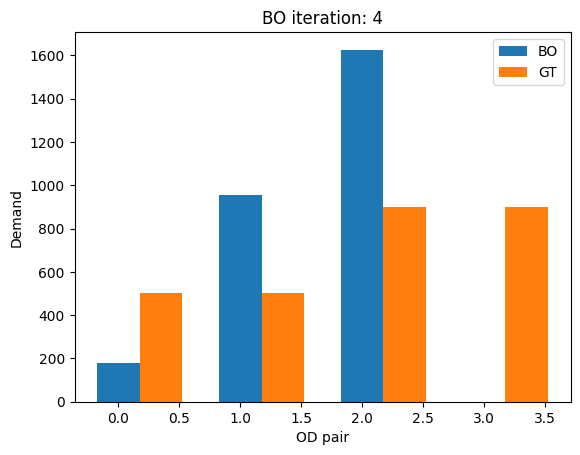

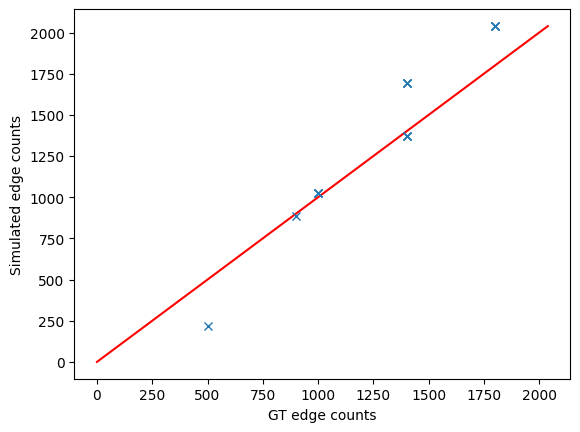

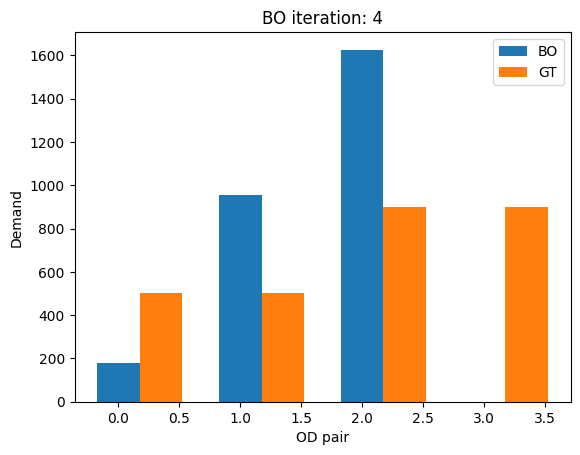

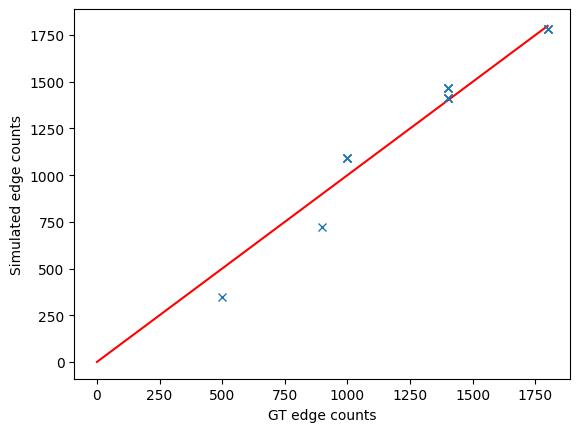

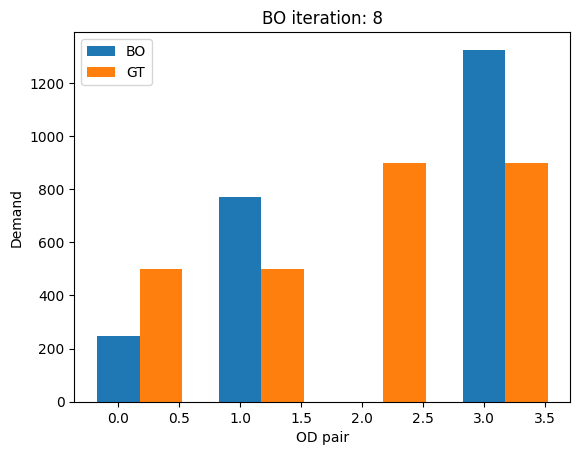

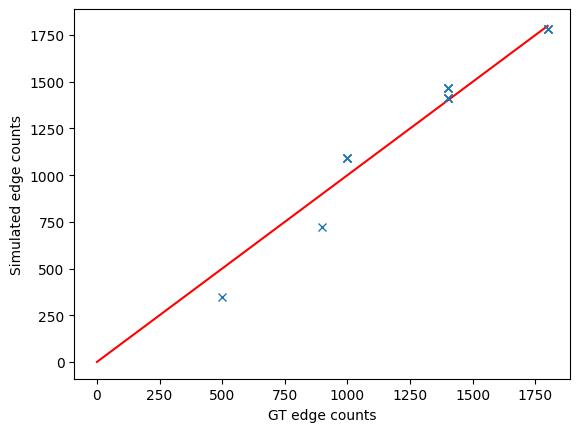

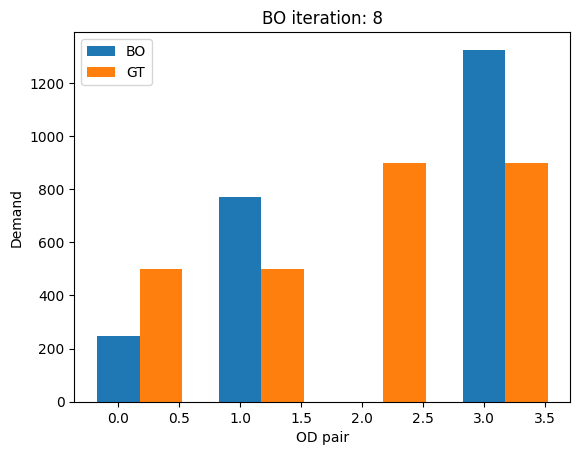

In [26]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss =compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x')
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts')
    plt.ylabel('Simulated edge counts')
    #plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_edge_counts.png")


    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    plt.title(f'BO iteration: {o1}')
    # plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_od.png")

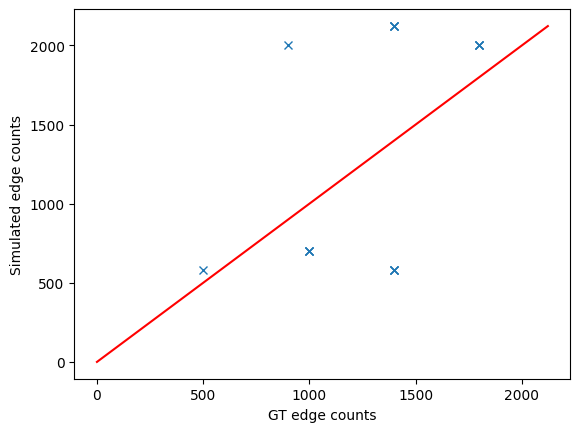

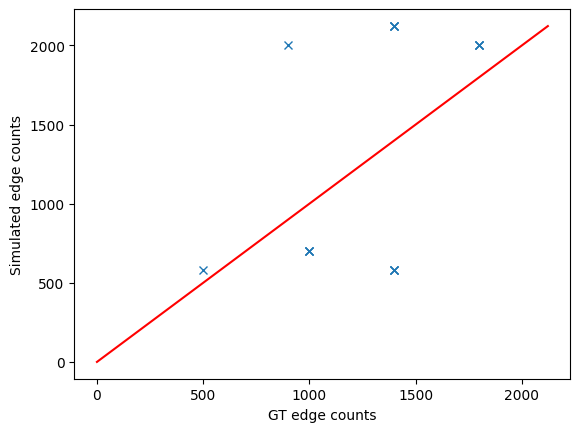

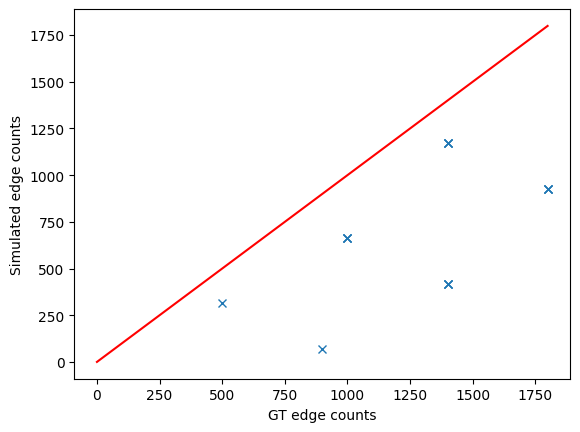

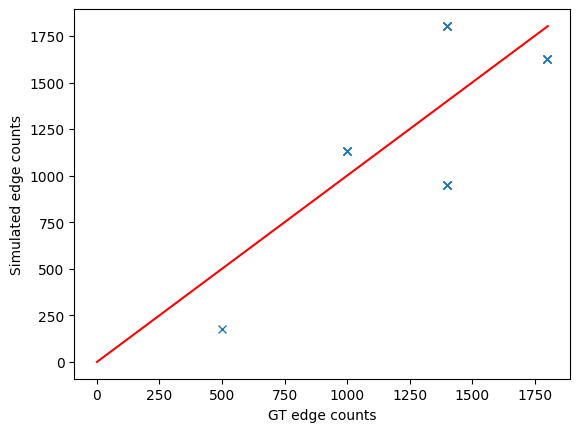

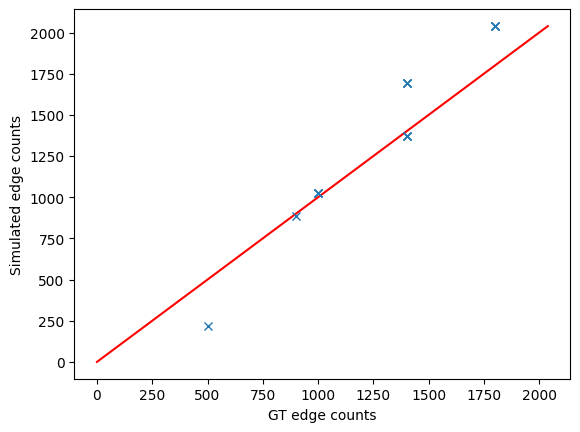

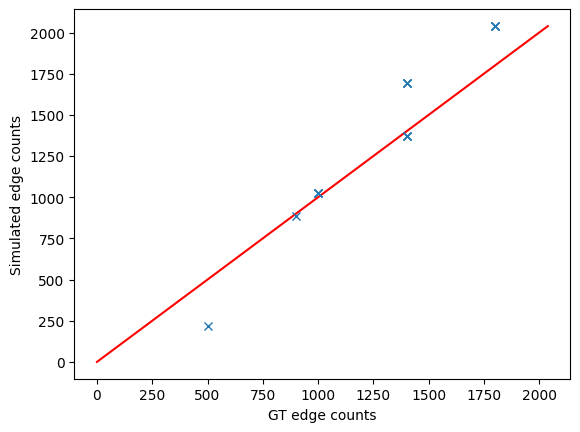

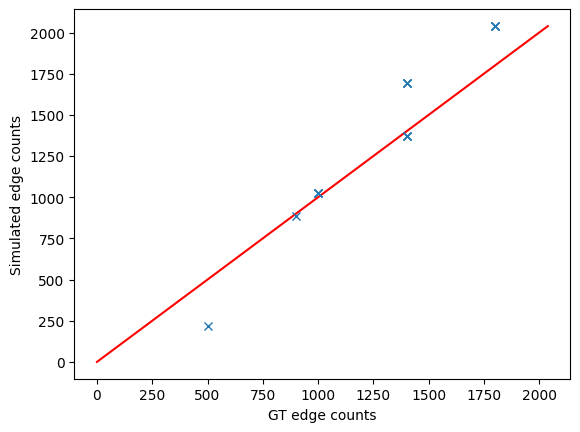

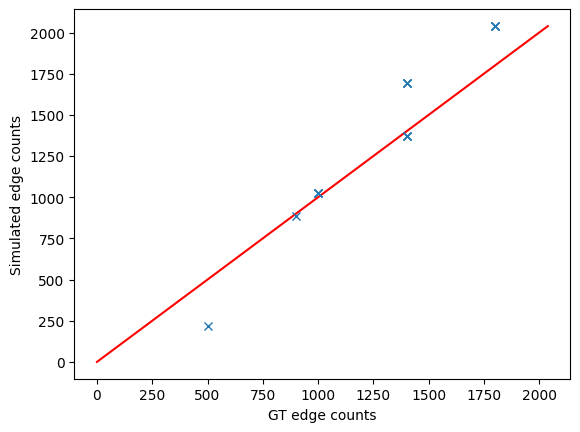

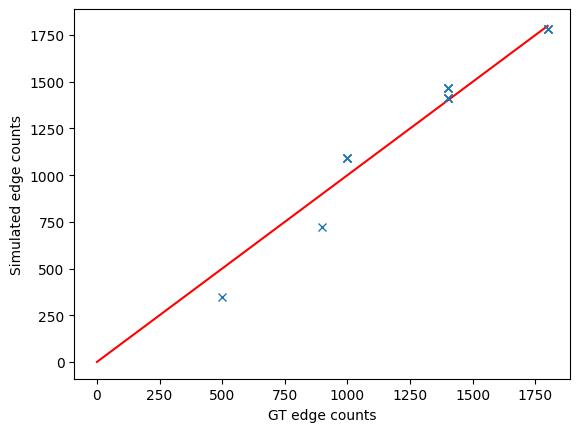

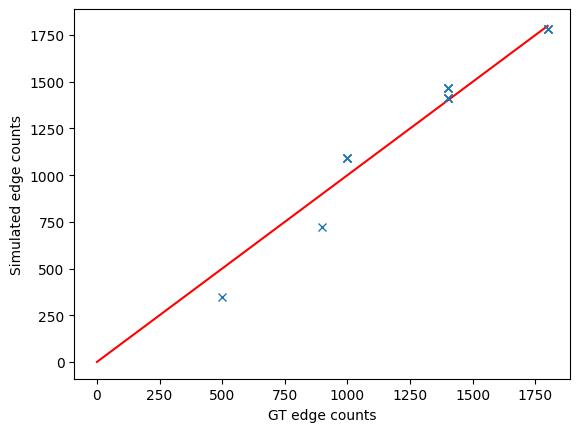

In [27]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x')
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts')
    plt.ylabel('Simulated edge counts')
    #plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_edge_counts.png")

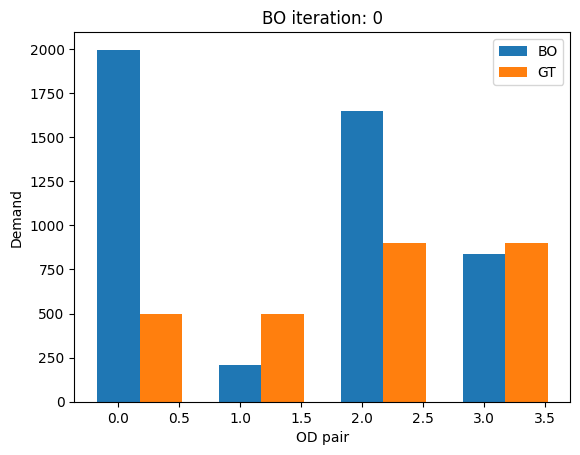

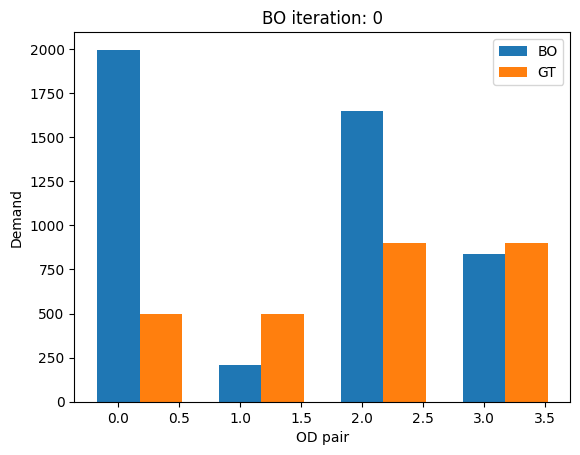

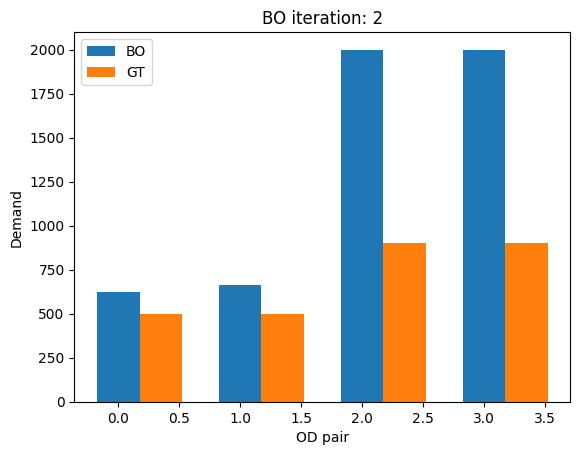

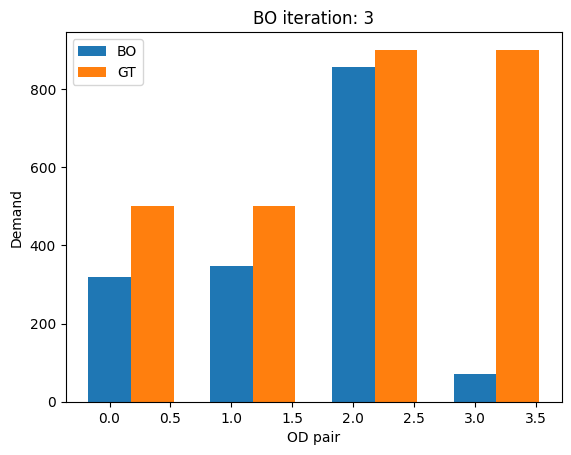

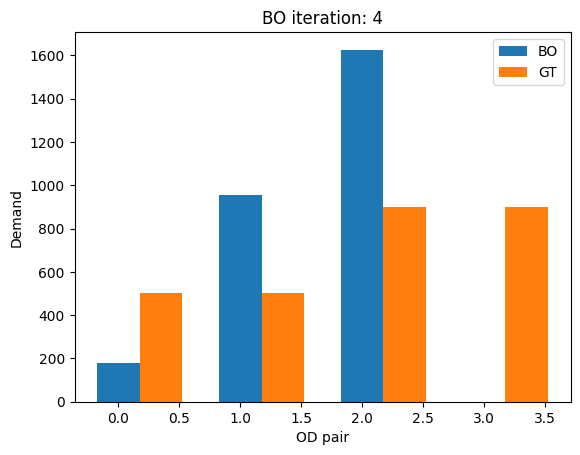

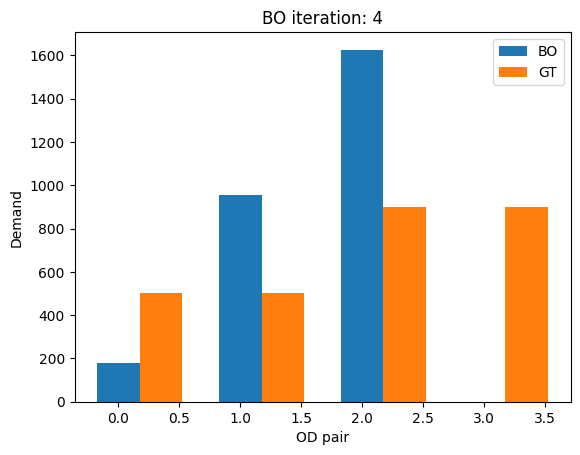

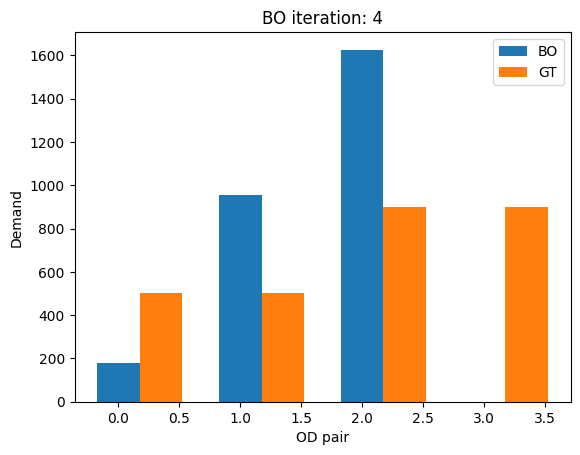

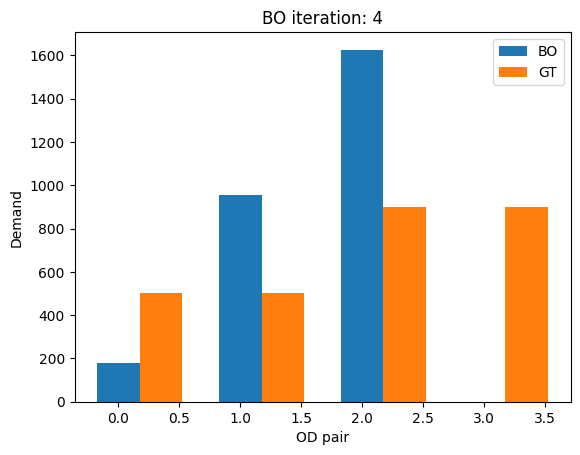

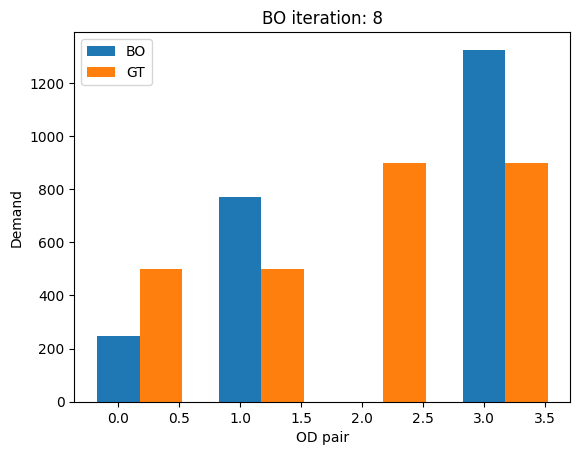

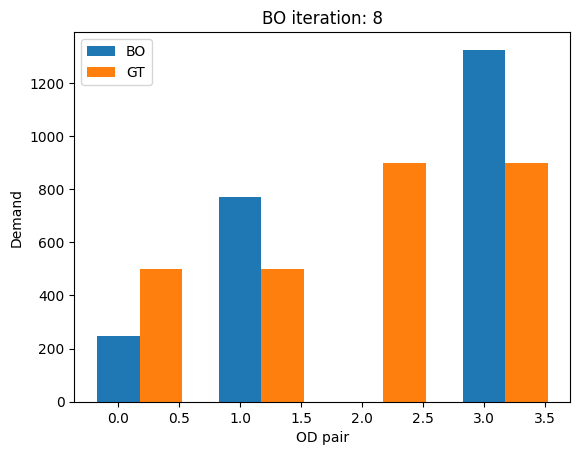

In [28]:
# disable interactive mode
#plt.ioff()
%matplotlib inline

if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    plt.title(f'BO iteration: {o1}')
    # plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_od.png")

In [29]:
# Columns corresponding to OD entries
od_cols = [c for c in df_training.columns if c.startswith("x_")]

# All OD vectors + loss, ordered by iteration
df_ods_all = df_training[["bo_iteration"] + od_cols + ["loss"]].sort_values(
    by=["bo_iteration"]
)

print("=== All tested ODs (initial design + BO) ===")
print(df_ods_all.to_string(index=False))

=== All tested ODs (initial design + BO) ===
 bo_iteration         x_1         x_2         x_3         x_4     loss
            0 1995.026708  208.732784 1645.957708  838.864326 1.542739
            0  905.401766 1676.134586  146.540940 1232.339859 0.866254
            0  436.367571  700.445175 1395.853519  347.931743 0.066142
            0 1463.984489 1168.594003  896.612585 1706.411481 1.275708
            0 1172.465086  780.603826  309.829950 1819.237351 0.562774
            1  579.804941  123.413273    0.000000 2000.000000 0.261002
            2  623.289407  661.473707 2000.000000 2000.000000 0.786186
            3  318.757002  345.771689  855.624746   70.777465 0.255893
            4  178.330899  952.776843 1626.223126    0.000000 0.146464
            5  217.723740  808.244846 1153.790490  885.951827 0.036385
            6  355.504247  980.298489 1063.447034  320.637463 0.072350
            7  425.060283  673.119255  775.969711 1261.743208 0.054378
            8  247.708837  770.4

In [30]:
df_ods_bo = df_training.loc[df_training["bo_iteration"] > 0,
                            ["bo_iteration"] + od_cols + ["loss"]].sort_values(
    by=["bo_iteration"]
)

print("=== ODs tested during BO only ===")
print(df_ods_bo.to_string(index=False))

=== ODs tested during BO only ===
 bo_iteration        x_1        x_2         x_3         x_4     loss
            1 579.804941 123.413273    0.000000 2000.000000 0.261002
            2 623.289407 661.473707 2000.000000 2000.000000 0.786186
            3 318.757002 345.771689  855.624746   70.777465 0.255893
            4 178.330899 952.776843 1626.223126    0.000000 0.146464
            5 217.723740 808.244846 1153.790490  885.951827 0.036385
            6 355.504247 980.298489 1063.447034  320.637463 0.072350
            7 425.060283 673.119255  775.969711 1261.743208 0.054378
            8 247.708837 770.419772    0.000000 1325.436497 0.247513
            9 348.149200 745.433027 1063.452745  720.321354 0.011806
           10 772.747724 471.336650    0.000000  703.268872 0.165506


In [31]:
edge_cols = ["bo_iteration", "batch", "edge_id", "interval_nVehContrib"]

df_edges_view = df_edge_stats[edge_cols].sort_values(
    by=["bo_iteration", "batch", "edge_id"]
)

print("=== Edge flows per BO iteration ===")
print(df_edges_view.to_string(index=False))

=== Edge flows per BO iteration ===
 bo_iteration  batch edge_id  interval_nVehContrib
            0      0      D2                 702.0
            0      0      D4                2000.0
            0      0      D5                 579.0
            0      0      D7                2123.0
            0      0     L10                2123.0
            0      0     L12                 702.0
            0      0     L14                2000.0
            0      0     L15                 579.0
            0      0     L16                2000.0
            0      0     L18                 579.0
            0      0      L2                 702.0
            0      0      L4                2000.0
            0      0      L5                 579.0
            0      0      L7                2123.0
            1      0      D2                1285.0
            1      0      D4                4000.0
            1      0      D5                2623.0
            1      0      D7                26

# best BO without multiple restart for vanilla analysis 

# convergence plot 

# Multiple restart 

In [48]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood


# =========================================================
# =============== PARAMETERS FOR MULTIPLE RUNS =============
# =========================================================
N_BO_RESTARTS = 5   # run the whole BO pipeline 5 times


# =========================================================
# =============== STORAGE ACROSS RESTARTS ==================
# =========================================================
all_best_traj = []     # stores best loss per iteration for each restart
all_final_best = []    # stores final best loss after last BO iteration


# =========================================================
# =============== BEGIN MULTIPLE BO RESTARTS ===============
# =========================================================
for r in range(N_BO_RESTARTS):

    print(f"\n\n==========================")
    print(f"   BO RESTART {r+1}/{N_BO_RESTARTS}")
    print(f"==========================\n\n")

    # Load NEW Sobol initial dataset for this restart
    df_0 = pd.read_csv(
        f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
    )

    # BO trajectory for this run
    best_value = []
    df_training = df_0.copy()
    df_training["bo_iteration"] = 0

    # ------------------------------------
    # Main BO LOOP
    # ------------------------------------
    for i in range(config["NITER"]):
        print(f"########### BO iteration={i+1} ###########")

        # 1. Extract training data
        train_X = torch.from_numpy(
            df_training[[col for col in df_training.columns if "x" in col]].values
        ).to(device=device, dtype=dtype)

        train_X_norm = normalize(train_X, bounds)

        train_Y = torch.from_numpy(df_training[["loss"]].values).to(dtype=dtype)

        best_y = train_Y.min()
        best_value.append(best_y.item())
        print(f"##### best_value={best_y.item()} #####")

        # 2. Fit GP
        gp_model, gp_mll = initialize_gp_model(train_X_norm, train_Y)
        fit_gpytorch_mll(gp_mll)

        # 3. Acquisition function
        EI = ExpectedImprovement(gp_model, best_f=best_y, maximize=False)

        # 4. Optimize acquisition → next OD vector
        x_i = optimize_acqf_and_get_observation(
            acq_func=EI,
            bounds=bounds_norm,
            device=device,
            dtype=dtype,
            BATCH_SIZE=config["BATCH_SIZE"],
            NUM_RESTARTS=config["NUM_RESTARTS"],
            RAW_SAMPLES=config["RAW_SAMPLES"],
        )
        x_i = unnormalize(x_i, bounds).cpu().numpy()

        # 5. Evaluate simulator
        batch_rows = []
        for j in range(config["BATCH_SIZE"]):
            curr_od = x_i[j]
            base_od['count'] = [round(v, 1) for v in curr_od]
            base_od_xml = f"{config['simulation_run_path']}/od.xml"

            create_taz_xml(
                base_od_xml,
                base_od.rename(columns={'fromTaz':'from','toTaz':'to'}),
                config["od_duration_sec"],
                base_path
            )

            prefix = f"{config['simulation_run_path']}/BO/restart{r}_iter{i}"
            simulate_od(
                base_od_xml,
                prefix,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"]
            )

            sim_edge_out = f"{prefix}_{config['EDGE_OUT_STR']}"
            stats, _, _ = parse_loop_data_xml_to_pandas(
                base_path, sim_edge_out, prefix, config["SUMO_PATH"]
            )

            loss = compute_nrmse_counts_all_edges(gt_edge_data, stats)
            print(f"############## loss: {loss} ##############")

            row = pd.DataFrame(
                curr_od.reshape(1, -1),
                columns=[f"x_{k+1}" for k in range(dim_od)]
            )
            row["loss"] = loss
            row["bo_iteration"] = i+1
            batch_rows.append(row)

        df_new = pd.concat(batch_rows)
        df_training = pd.concat([df_training, df_new])

    # =============== SAVE FULL TRAINING DF FOR THIS RESTART ===============
    save_path = f"{config['simulation_run_path']}/BO/restart{r}_full_training.csv"
    df_training.to_csv(save_path, index=False)
    print(f"Saved full training data for restart {r+1} to: {save_path}")

    # Save trajectory for this restart
    all_best_traj.append(best_value)
    all_final_best.append(best_value[-1])


# =========================================================
# =============== PRINT ACROSS-RESTART VARIABILITY =========
# =========================================================
print("\n\n========================================")
print("     ACROSS-RESTART VARIABILITY")
print("========================================\n")

for r, traj in enumerate(all_best_traj):
    print(f"Restart {r+1}: Final best loss = {traj[-1]:.6f}")

mean_final = np.mean(all_final_best)
std_final  = np.std(all_final_best)
best_overall = np.min(all_final_best)

print("\n--- Summary ---")
print(f"Mean final loss      : {mean_final:.6f}")
print(f"Std dev final loss   : {std_final:.6f}")
print(f"Best final loss       : {best_overall:.6f}")
print(f"All final losses      : {all_final_best}")

print("\nBO trajectories shape:", np.array(all_best_traj).shape)



   BO RESTART 1/5


########### BO iteration=1 ###########
##### best_value=0.0661424585897851 #####
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter0_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter1_trips.xml'
Loading done.
Simulation version 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter2_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.84
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter3_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.81
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter4_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter5_trips_beforeRteUpdates.xml
Success.time 299.53
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter6_trips_beforeRteUpdates.xml
Success.time 299.64
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter7_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter8_trips_beforeRteUpdates.xml
Success.time 299.29
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter9_trips_beforeRteUpdates.xml
Success.time 299.36
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (1ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter1_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter2_trips_beforeRteUpdates.xml
Success.time 299.35
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter3_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter4_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.93
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter5_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter6_trips_beforeRteUpdates.xml
Success.time 299.26
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.95
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter7_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter8_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter9_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter1_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter2_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter3_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter4_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter5_trips_beforeRteUpdates.xml
Success.time 299.06
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter6_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter7_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter8_trips_beforeRteUpdates.xml
Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter9_trips_beforeRteUpdates.xml
Success.time 299.39
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter1_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter2_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter3_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter4_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter5_trips_beforeRteUpdates.xml
Success.time 299.06
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter6_trips_beforeRteUpdates.xml
Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter7_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter8_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.39
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter9_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter1_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter2_trips_beforeRteUpdates.xml
Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter3_trips_beforeRteUpdates.xml
Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter4_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter5_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter6_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1763 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.37s
 Real time factor: 157808
 UPS: 2401443.835616
Vehicles:
 Inserted: 1763
 Running: 0
 Waiting: 0
Statistics (avg of 1763):
 RouteLength: 4606.02
 Speed: 9.53
 Duration: 497.18
 WaitingTime: 0.46
 TimeLoss: 160.43
 DepartDelay: 348.02
DijkstraRouter answered 3324 queries and explored 11.53 edges on average.
DijkstraRouter spent 0.00s 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.93
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter7_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter8_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2286 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.45s
 Real time factor: 128859
 UPS: 2138123.042506
Vehicles:
 Inserted: 2286
 Running: 0
 Waiting: 0
Statistics (avg of 2286):
 RouteLength: 4116.66
 Speed: 9.92
 Duration: 418.08
 WaitingTime: 0.32
 TimeLoss: 117.30
 DepartDelay: 485.45
DijkstraRouter answered 4401 queries and explored 9.58 edges on average.
DijkstraRouter spent 0.00s a

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter9_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file



   BO RESTART 1/5


########### BO iteration=1 ###########
##### best_value=0.0661424585897851 #####
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter0_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter1_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2892 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.68s
 Real time factor: 85081.2
 UPS: 2785850.812408
Vehicles:
 Inserted: 2892
 Running: 0
 Waiting: 0
Statistics (avg of 2892):
 RouteLength: 4681.30
 Speed: 7.64
 Duration: 652.15
 WaitingTime: 0.97
 TimeLoss: 310.02
 DepartDelay: 795.59
DijkstraRouter answered 5616 queries and explored 11.87 edges on average.
DijkstraRouter spent 0.00s

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter2_trips_beforeRteUpdates.xml
Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter3_trips_beforeRteUpdates.xml
Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter4_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.06
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter5_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter6_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter7_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter8_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.39
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart0_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart0_iter9_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter1_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter2_trips_beforeRteUpdates.xml
Success.time 299.35
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter3_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter4_trips_beforeRteUpdates.xml
Success.time 299.52
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter5_trips_beforeRteUpdates.xml
Success.time 299.75
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter6_trips_beforeRteUpdates.xml
Success.time 299.25
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.75
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter7_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter8_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter9_trips_beforeRteUpdates.xml
Success.time 299.34
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart1_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart1_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.28
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter1_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter2_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.84
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter3_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.81
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter4_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter5_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter6_trips_beforeRteUpdates.xml
Success.time 299.64
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter7_trips_beforeRteUpdates.xml
Success.time 299.66
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.79
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter8_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.93
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart2_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart2_iter9_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter1_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter2_trips_beforeRteUpdates.xml
Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter3_trips_beforeRteUpdates.xml
Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter4_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.06
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter5_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter6_trips_beforeRteUpdates.xml
Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter7_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter8_trips_beforeRteUpdates.xml
Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.39
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart3_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart3_iter9_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter0_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter0_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter1_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter1_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter1_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter2_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter2_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter2_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter3_trips_beforeRteUpdates.xml
Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter3_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter3_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter4_trips_beforeRteUpdates.xml
Success.time 299.33
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter4_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter4_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.06
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter5_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter5_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter5_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter6_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter6_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter6_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter7_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter7_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter7_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter8_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter8_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter8_trips.xml'
Loading done.

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter9_trips_beforeRteUpdates.xml
Success.time 299.39
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/BO/restart4_iter9_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/BO/restart4_iter9_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file

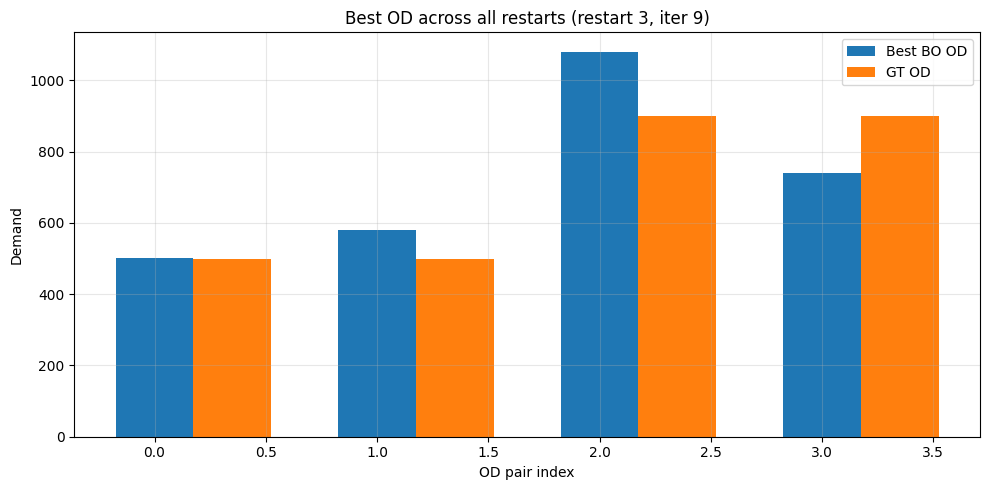

In [53]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt

from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood


# =========================================================
# =============== PARAMETERS FOR MULTIPLE RUNS =============
# =========================================================
N_BO_RESTARTS = 5   # run the whole BO pipeline 5 times


# =========================================================
# =============== STORAGE ACROSS RESTARTS ==================
# =========================================================
all_best_traj = []     # stores best loss per iteration for each restart
all_final_best = []    # stores final best loss after last BO iteration


# =========================================================
# =============== BEGIN MULTIPLE BO RESTARTS ===============
# =========================================================
for r in range(N_BO_RESTARTS):

    print(f"\n\n==========================")
    print(f"   BO RESTART {r+1}/{N_BO_RESTARTS}")
    print(f"==========================\n\n")

    # Load Sobol initial dataset (same file for all restarts)
    df_0 = pd.read_csv(
        f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
    )

    # BO trajectory for this run
    best_value = []
    df_training = df_0.copy()
    df_training["bo_iteration"] = 0

    # ------------------------------------
    # Main BO LOOP
    # ------------------------------------
    for i in range(config["NITER"]):
        print(f"########### BO iteration={i+1} ###########")

        # 1. Extract training data
        train_X = torch.from_numpy(
            df_training[[col for col in df_training.columns if "x" in col]].values
        ).to(device=device, dtype=dtype)

        train_X_norm = normalize(train_X, bounds)

        train_Y = torch.from_numpy(df_training[["loss"]].values).to(dtype=dtype)

        best_y = train_Y.min()
        best_value.append(best_y.item())
        print(f"##### best_value={best_y.item()} #####")

        # 2. Fit GP
        gp_model, gp_mll = initialize_gp_model(train_X_norm, train_Y)
        fit_gpytorch_mll(gp_mll)

        # 3. Acquisition function
        EI = ExpectedImprovement(gp_model, best_f=best_y, maximize=False)

        # 4. Optimize acquisition → next OD vector
        x_i = optimize_acqf_and_get_observation(
            acq_func=EI,
            bounds=bounds_norm,
            device=device,
            dtype=dtype,
            BATCH_SIZE=config["BATCH_SIZE"],
            NUM_RESTARTS=config["NUM_RESTARTS"],
            RAW_SAMPLES=config["RAW_SAMPLES"],
        )
        x_i = unnormalize(x_i, bounds).cpu().numpy()

        # 5. Evaluate simulator
        batch_rows = []
        for j in range(config["BATCH_SIZE"]):
            curr_od = x_i[j]

            # update base_od counts
            base_od['count'] = [round(v, 1) for v in curr_od]
            base_od_xml = f"{config['simulation_run_path']}/od.xml"

            create_taz_xml(
                base_od_xml,
                base_od.rename(columns={'fromTaz':'from','toTaz':'to'}),
                config["od_duration_sec"],
                base_path
            )

            prefix = f"{config['simulation_run_path']}/BO/restart{r}_iter{i}"
            simulate_od(
                base_od_xml,
                prefix,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"],
            )

            sim_edge_out = f"{prefix}_{config['EDGE_OUT_STR']}"
            stats, _, _ = parse_loop_data_xml_to_pandas(
                base_path, sim_edge_out, prefix, config["SUMO_PATH"]
            )

            loss = compute_nrmse_counts_all_edges(gt_edge_data, stats)
            print(f"############## loss: {loss} ##############")

            row = pd.DataFrame(
                curr_od.reshape(1, -1),
                columns=[f"x_{k+1}" for k in range(dim_od)]
            )
            row["loss"] = loss
            row["bo_iteration"] = i+1
            batch_rows.append(row)

        df_new = pd.concat(batch_rows)
        df_training = pd.concat([df_training, df_new], ignore_index=True)

    # -------------------------------
    # SUCCESS NEW: Save full training of this restart
    # -------------------------------
    out_csv = f"{config['simulation_run_path']}/BO/restart{r}_full_training.csv"
    df_training.to_csv(out_csv, index=False)
    print(f"Saved full training data for restart {r} to: {out_csv}")

    # Save trajectory for this restart
    all_best_traj.append(best_value)
    all_final_best.append(best_value[-1])


# =========================================================
# =============== PRINT ACROSS-RESTART VARIABILITY =========
# =========================================================
print("\n\n========================================")
print("     ACROSS-RESTART VARIABILITY")
print("========================================\n")

for r, traj in enumerate(all_best_traj):
    print(f"Restart {r+1}: Final best loss = {traj[-1]:.6f}")

mean_final = np.mean(all_final_best)
std_final  = np.std(all_final_best)
best_overall = np.min(all_final_best)

print("\n--- Summary ---")
print(f"Mean final loss      : {mean_final:.6f}")
print(f"Std dev final loss   : {std_final:.6f}")
print(f"Best final loss       : {best_overall:.6f}")
print(f"All final losses      : {all_final_best}")

print("\nBO trajectories shape:", np.array(all_best_traj).shape)


# =========================================================
# =============== SUCCESS PLOT BEST OD VS GT ====================
# =========================================================

# 1) which restart achieved the best final loss?
best_restart_idx = int(np.argmin(all_final_best))
print(f"\n>>> Best restart index (0-based): {best_restart_idx}")

# 2) load its full training data
best_df_path = f"{config['simulation_run_path']}/BO/restart{best_restart_idx}_full_training.csv"
df_best = pd.read_csv(best_df_path)

# 3) row with the minimum loss over this restart
best_row = df_best.loc[df_best["loss"].idxmin()]
best_od_vector = best_row[[c for c in df_best.columns if c.startswith("x_")]].values
best_it = int(best_row["bo_iteration"])

print(f">>> Best iteration within restart {best_restart_idx}: {best_it}")
print(">>> Best OD vector (first 10 entries):", best_od_vector[:10])

# 4) bar plot: BO OD vs GT OD
plt.figure(figsize=(10, 5))

width = 0.35
idx = np.arange(len(best_od_vector))

plt.bar(idx, best_od_vector, width, label="Best BO OD")
plt.bar(idx + width, gt_od_vals, width, label="GT OD")

plt.xlabel("OD pair index")
plt.ylabel("Demand")
plt.title(
    f"Best OD across all restarts "
    f"(restart {best_restart_idx}, iter {best_it})"
)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# optionally save
fig_dir = Path(f"{config['simulation_run_path']}/figs")
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / "best_OD_across_restarts.png", dpi=300)

plt.show()

In [ ]:
# =========================================================
# =============== CONVERGENCE CURVES (VANILLA BO) ======
# =========================================================

traj_array = np.array(all_best_traj)  # shape: (N_BO_RESTARTS, NITER)
n_restarts, n_iters = traj_array.shape

mean_curve = traj_array.mean(axis=0)
std_curve  = traj_array.std(axis=0)

plt.figure(figsize=(12, 5))

# plot each restart trajectory
for r in range(n_restarts):
    plt.plot(traj_array[r], alpha=0.4, label=f"Restart {r+1}")

# plot mean and std band
plt.plot(mean_curve, color="black", linewidth=2, label="Mean best-so-far")

plt.fill_between(
    np.arange(n_iters),
    mean_curve - std_curve,
    mean_curve + std_curve,
    color="gray",
    alpha=0.2,
    label="±1 std",
)

plt.xlabel("BO iteration")
plt.ylabel("Loss (NRMSE or S)")
plt.title("BO Convergence Across Restarts (Vanilla BO)")
plt.legend()
plt.grid(alpha=0.3)

fig_dir = Path(f"{config['simulation_run_path']}/figs")
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / "convergence_curves_vanillaBO.png", dpi=300)

plt.show()